## This notebook will implement number of experiments on the normal and anomaly data using Kolmogorov-Smirnov Test (KS Test)

Datasets:

| **Normal** | **Anomaly**                                                    |
|------------|----------------------------------------------------------------|
| building   | laser_fault/building                                           |
| cans       | laser_fault/cans, obstacle/cans                                |
| corr       | laser_fault/corr, obstacle/corr                                |
| pick       | pick/miss_cup, pick/restricted_vision, pick/stolen, pick/stuck |
| -          | software_fault                                                 |
| -          | velocity_attack                                                |
| real_panda | change_obj_weight, gripper_attack, low_net_connection, miss_bubble|
| real_turtlebot3| collision, hardware_fault, low_net_connection, unmapped_obstacle, velocity_attack|
| sim_panda  | collision, drop_early, gripper_attack                          |
| sim_turtlebot3 | laser_fault, unmapped_obstacle, velocity_attack            |

Cans - map name
Corr - map name

In [61]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve
import pandas as pd

In the first experiment, we will test anomaly detection on building navigation. The normal data contains regular navigation in the environment. The anomaly contains various navigation scenarios and problems while navigation like obstacles, faults of the components, etc.

In [62]:
# Consts
INF=0
SUP=200
TOTAL_ACC = 0.0
EXP_NUM = 0

AUROCs = []

In [63]:
columns = []
def load_directory(directory, file_prefix):
    runs = []
    for i in range(len(os.listdir(directory))):
        f = os.path.join(directory, file_prefix + str(i + 1) + ".csv")
        if os.path.isfile(f):
            runs.append(np.genfromtxt(f, delimiter=",", skip_header=1))
            columns.extend(np.genfromtxt(f, dtype=str, delimiter=",")[0])
    return runs, np.concatenate([np.reshape(r, -1) for r in runs])

def plot_hist(runs, title):
    fig, axs = plt.subplots(1)
    for i, r in enumerate(runs):
        axs.hist(np.reshape(r[np.logical_and(r>INF, r<SUP)], -1), bins='auto', density=True)
    axs.set_title(title)
    axs.set_xlim((INF,SUP))
    
def ks_test(runs, more_runs=[]):
    ks_test = []
    if len(more_runs) == 0: # Compare to itself
        for j, rj in enumerate(runs):
            other_runs = np.concatenate([np.reshape(runs[i], -1) for i in range(len(runs)) if i != j])
            ks_test.append(ks_2samp(np.reshape(other_runs, -1), np.reshape(rj, -1)).statistic)
    else: # Compare to other
        n = 2
        # more_runs - it's normal_normal runs
        # runs - it's potentialy anomaly runs
        for j, rj in enumerate(runs):
            rj = rj[len(rj)*(n-2)//3:]
            ks_test.append(ks_2samp(np.reshape(more_runs, -1), np.reshape(rj, -1)).statistic)
    return ks_test

def plot_ks_test_results(norm_norm, norm_anomaly, anomaly_anomaly, title=''):
    plt.title(title)
    plt.hist(ks_normal_normal, bins="auto", density=True, alpha=0.5, label='normal vs normal')
    plt.hist(ks_normal_anomaly, bins="auto", density=True, alpha=0.5, label='anomaly vs normal')
    plt.hist(ks_anomaly_anomaly, bins="auto", density=True, alpha=0.5, label='anomaly vs anomaly')
    plt.legend()
    plt.savefig(title + '.png')
    
def threshold_dist(norm_norm, threshold_percent=0.95):
    sorted_n_n = norm_norm.copy()
    sorted_n_n.sort(reverse=False)
    threshold_index = int(len(sorted_n_n) * threshold_percent)
#     print(sorted_n_n, threshold_index)
    avg_dist = np.min(sorted_n_n[threshold_index:])
    print('Min distance of ' + str((threshold_percent * 100)) + '% confidence level:', avg_dist)
    return avg_dist

def detect_anomalies(norm_anomaly, norm_norm, threshold_percent=0.9, title="ROC"):
    global EXP_NUM
    global TOTAL_ACC
    EXP_NUM += 1
    avg_dist = threshold_dist(norm_norm, threshold_percent)
    count_anom = [1 if i >= avg_dist else 0 for i in norm_anomaly ]
    TOTAL_ACC += sum(count_anom) * 100/len(norm_anomaly)
    print('Total anomalies detected:', sum(count_anom), 'of', len(norm_anomaly), ', accuracy:' + str(sum(count_anom)*100/len(norm_anomaly)) + '%')

    # The x-axis showing 1 – specificity (= false positive fraction = FP/(FP+TN))
    # The y-axis showing sensitivity (= true positive fraction = TP/(TP+FN))
    x = []
    y = []
    nn_copy = norm_norm.copy()
    nn_copy.sort(reverse=True)
    for t in nn_copy:
        true_positive = sum([1 if i >= t else 0 for i in norm_anomaly ])
        true_negative = sum([1 if i < t else 0 for i in norm_norm ])
        false_positive = sum([1 if i >= t else 0 for i in norm_norm ]) 
        false_negative = sum([1 if i < t else 0 for i in norm_anomaly ]) 
        x.append(false_positive/(false_positive + true_negative))
        y.append(true_positive/(true_positive + false_negative))
    
    np.savetxt('x_' + title + '.csv', x, delimiter=",")
    np.savetxt('y_' + title + '.csv', y, delimiter=",")
    fig, axs = plt.subplots(1)
    axs.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
    axs.plot(x, y, marker='o')
    axs.plot(axs.get_xlim(), axs.get_ylim(), ls="--", c=".3")
    axs.set_title(title)
    axs.set_ylabel('True Positive Rate')
    axs.set_xlabel('False Positive Rate')
    plt.show()
    fig.savefig(title + '.png')
    auroc = 0
    for i in range(len(x)-1):
        auroc +=((x[i+1]-x[i]) * (y[i+1]+y[i]))/2
    print('AUROC:', auroc)
    return [title.replace("ROC", ''), auroc]
    

# Laser Fault

## Loading building and laser faults data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/laser_fault/building/counts_laser_fault_build*.csv```

In [64]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with laser fault'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/building'
ANOM_FILE_PREFIX = 'counts_laser_fault_build'

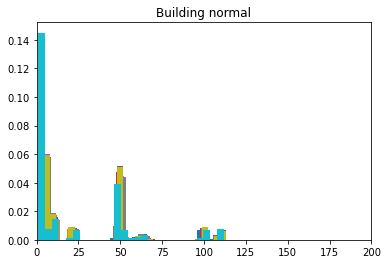

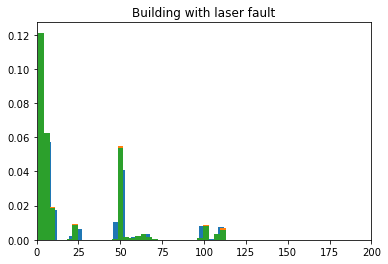

In [65]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Laser fault KS Test

Anomaly Max dist: 0.011147330503300523  Anomaly Min dist:  0.00971543086172355
Min distance of 90.0% confidence level: 0.010434613600547427
Total anomalies detected: 2 of 3 , accuracy:66.66666666666667%


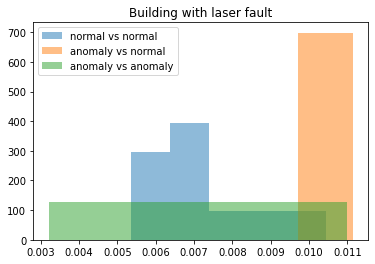

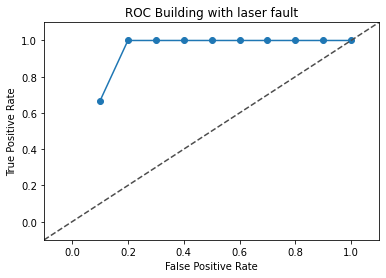

AUROC: 0.8833333333333333


In [66]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Software fault

## Loading building and software faults data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/software_fault/counts_software_fault_*.csv```

In [67]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with software fault'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/software_fault'
ANOM_FILE_PREFIX = 'counts_software_fault_'

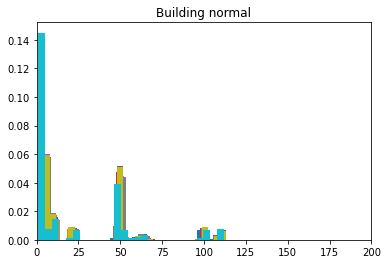

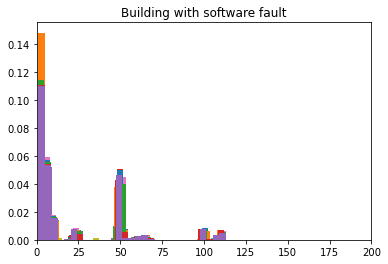

In [68]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)
anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Software fault KS Test

Anomaly Max dist: 0.12254170693457922  Anomaly Min dist:  0.11821770024302602
Min distance of 90.0% confidence level: 0.010434613600547427
Total anomalies detected: 15 of 15 , accuracy:100.0%


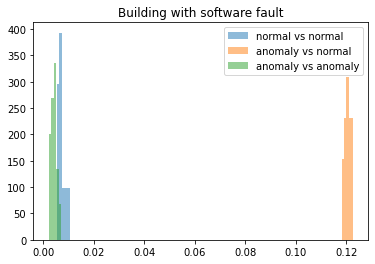

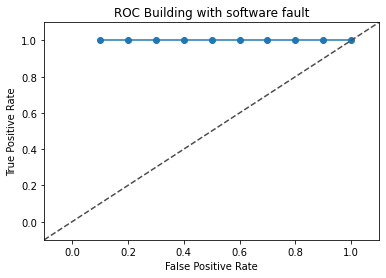

AUROC: 0.9


In [69]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Velocity attack

## Loading building and velocity attack data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/velocity_attack/counts_velocity_attack_*.csv```

In [70]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with velocity attack'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/velocity_attack'
ANOM_FILE_PREFIX = 'counts_velocity_attack_'

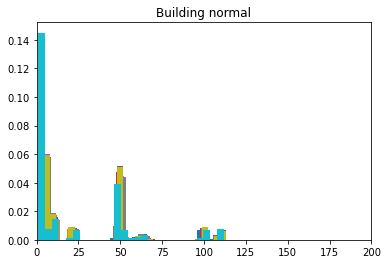

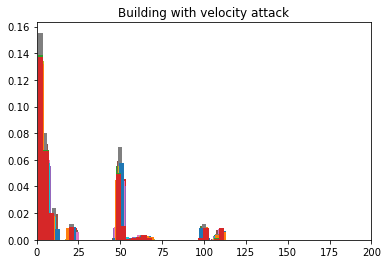

In [71]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Velocity attack KS Test

Anomaly Max dist: 0.12677619541877239  Anomaly Min dist:  0.10410036597411354
Min distance of 90.0% confidence level: 0.010434613600547427
Total anomalies detected: 14 of 14 , accuracy:100.0%


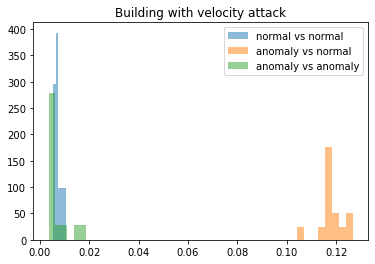

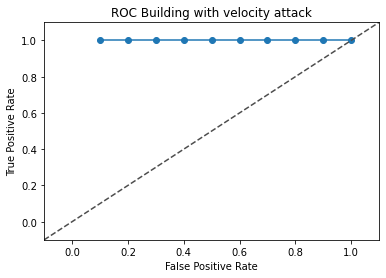

AUROC: 0.9


In [72]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Cans Laser fault

## Loading Cans and Laser fault data

```data/normal/cans/counts_normal_cans*.csv```

```data/anomaly/laser_fault/cans/counts_laser_fault_cans*.csv```

In [73]:
TITLE_NORMAL = 'Cans normal'
TITLE_ANOMALY = 'Cans with Laser fault'
NORM_COUNTS_PATH = './data/normal/cans'
NORM_FILE_PREFIX = 'counts_normal_cans'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/cans'
ANOM_FILE_PREFIX = 'counts_laser_fault_cans'

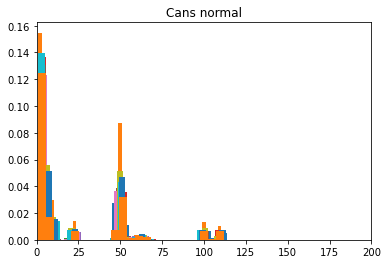

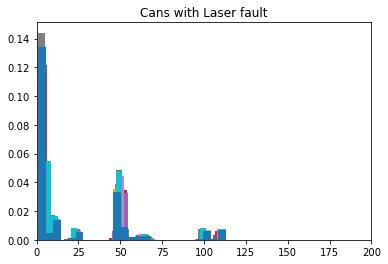

In [74]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Cans Laser fault KS Test

Anomaly Max dist: 0.01547212408495624  Anomaly Min dist:  0.011254595318927807
Min distance of 90.0% confidence level: 0.01650667271774009
Total anomalies detected: 0 of 11 , accuracy:0.0%


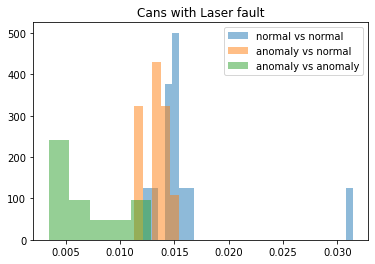

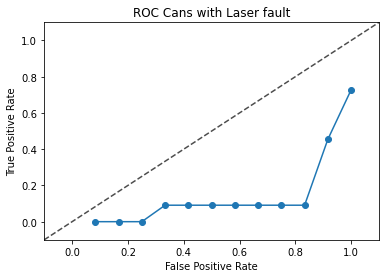

AUROC: 0.12121212121212123


In [75]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Cans Obstacles

## Loading Cans and Obstacles data

```data/normal/cans/counts_normal_cans*.csv```

```data/anomaly/obstacle/cans/counts_laser_fault_cans*.csv```

In [76]:
TITLE_NORMAL = 'Cans normal'
TITLE_ANOMALY = 'Cans with Obstacles'
NORM_COUNTS_PATH = './data/normal/cans'
NORM_FILE_PREFIX = 'counts_normal_cans'
ANOMALY_COUNTS_PATH = './data/anomaly/obstacle/cans'
ANOM_FILE_PREFIX = 'counts_obs_cans'

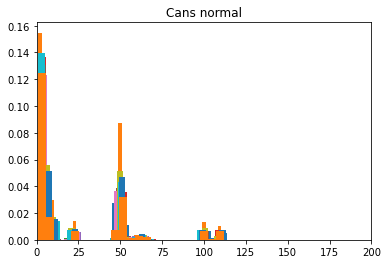

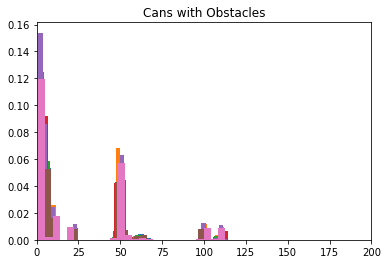

In [77]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Cans Obstacle KS Test

Anomaly Max dist: 0.07574226808919404  Anomaly Min dist:  0.008601005562507535
Min distance of 90.0% confidence level: 0.01650667271774009
Total anomalies detected: 2 of 7 , accuracy:28.571428571428573%


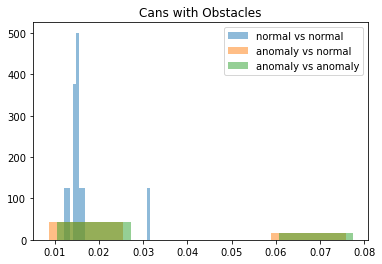

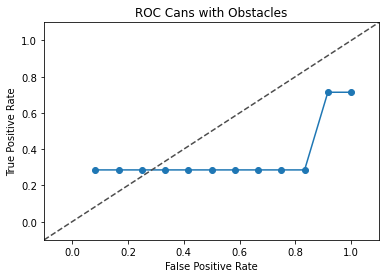

AUROC: 0.3154761904761904


In [78]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Corr Laser fault

## Loading Corr and Laser fault data

```data/normal/corr/counts_normal_corr_rand*.csv```

```data/anomaly/laser_fault/corr/counts_laser_fault_corr_rand*.csv```

In [79]:
TITLE_NORMAL = 'Corr normal'
TITLE_ANOMALY = 'Corr with Laser fault'
NORM_COUNTS_PATH = './data/normal/corr'
NORM_FILE_PREFIX = 'counts_normal_corr_rand'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/corr'
ANOM_FILE_PREFIX = 'counts_laser_fault_corr_rand'

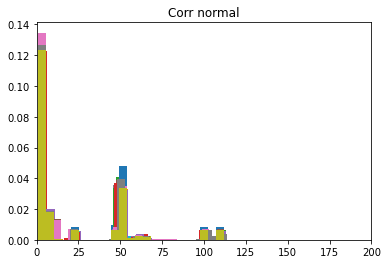

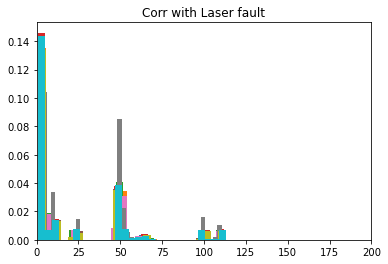

In [80]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Corr Laser fault KS Test

Anomaly Max dist: 0.10626211375320893  Anomaly Min dist:  0.009973020118381748
Min distance of 90.0% confidence level: 0.010120379630341847
Total anomalies detected: 9 of 10 , accuracy:90.0%


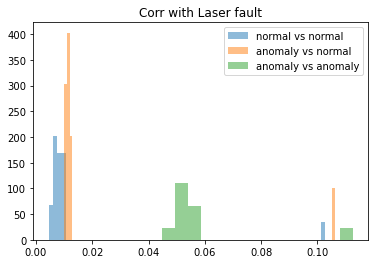

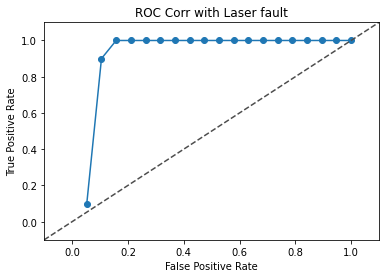

AUROC: 0.918421052631579


In [81]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Corr Obstacles

## Loading Corr and Obstacles data

```data/normal/corr/counts_normal_corr_rand*.csv```

```data/anomaly/obstacle/corr/counts_laser_fault_cans*.csv```

In [82]:
TITLE_NORMAL = 'Corr normal'
TITLE_ANOMALY = 'Corr with Obstacles'
NORM_COUNTS_PATH = './data/normal/corr'
NORM_FILE_PREFIX = 'counts_normal_corr_rand'
ANOMALY_COUNTS_PATH = './data/anomaly/obstacle/corr'
ANOM_FILE_PREFIX = 'counts_obs_corr_rand'

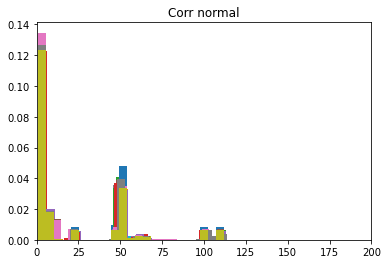

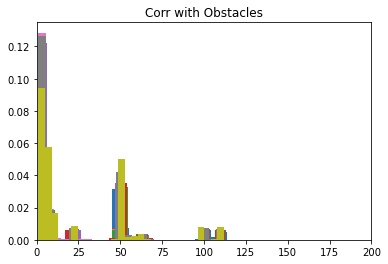

In [83]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Corr Obstacle KS Test

Anomaly Max dist: 0.01893165578613687  Anomaly Min dist:  0.005831608122221499
Min distance of 90.0% confidence level: 0.010120379630341847
Total anomalies detected: 2 of 9 , accuracy:22.22222222222222%


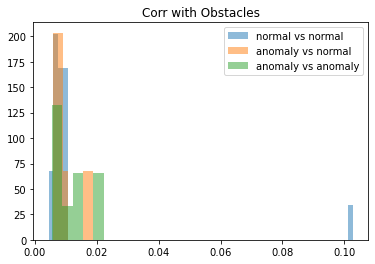

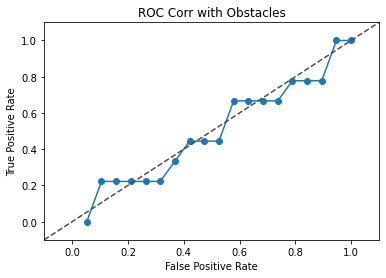

AUROC: 0.48830409356725146


In [84]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and miss cup

## Loading pick and miss cup data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/miss_cup/counts_miss_cup*.csv```

In [85]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and miss cup'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/miss_cup'
ANOM_FILE_PREFIX = 'counts_miss_cup'

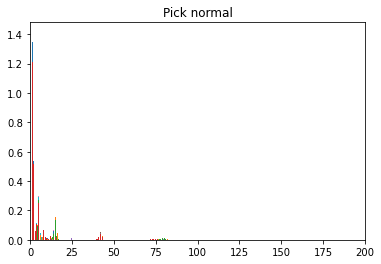

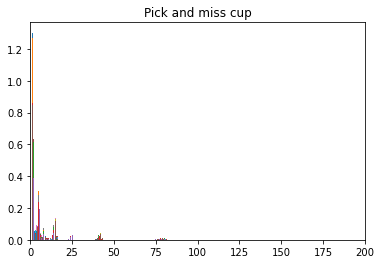

In [86]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and miss cup KS Test

Anomaly Max dist: 0.1123628991367126  Anomaly Min dist:  0.0077835735414824025
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 4 of 16 , accuracy:25.0%


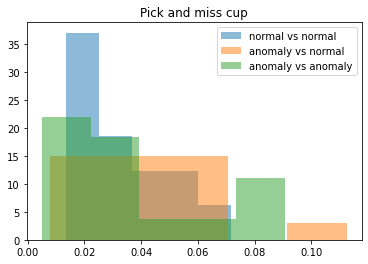

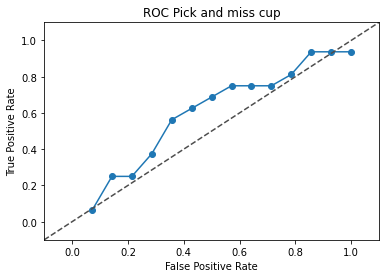

AUROC: 0.5848214285714286


In [87]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and restricted vision

## Loading pick and restricted vision data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/restricted_vision/counts_restricted_vision*.csv```

In [88]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and restricted vision'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/restricted_vision'
ANOM_FILE_PREFIX = 'counts_restricted_vision'

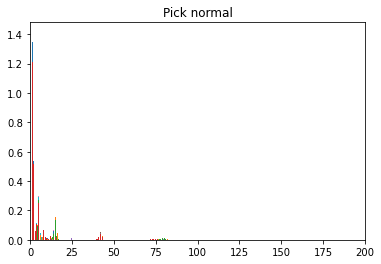

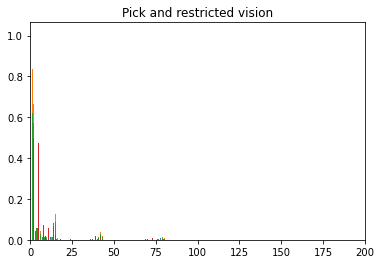

In [89]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and restricted vision KS Test

Anomaly Max dist: 0.37576487062191904  Anomaly Min dist:  0.08387039756656134
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 4 of 4 , accuracy:100.0%


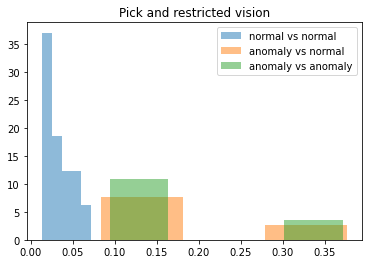

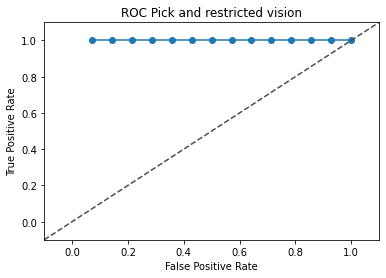

AUROC: 0.9285714285714285


In [90]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and stolen cup

## Loading pick and stolen cup data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/stolen/counts_cup_stolen*.csv```

In [91]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and stolen'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/stolen'
ANOM_FILE_PREFIX = 'counts_cup_stolen'

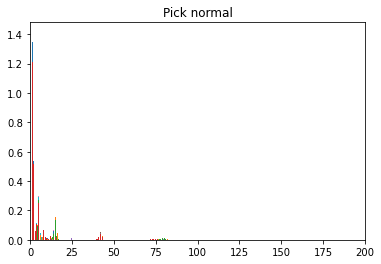

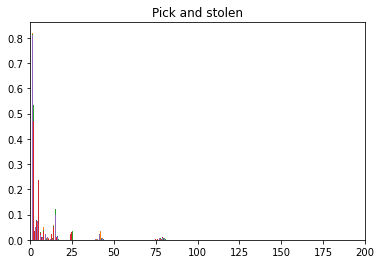

In [92]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and stolen cup KS Test

Anomaly Max dist: 0.08576668266707843  Anomaly Min dist:  0.07159612174274044
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 5 of 5 , accuracy:100.0%


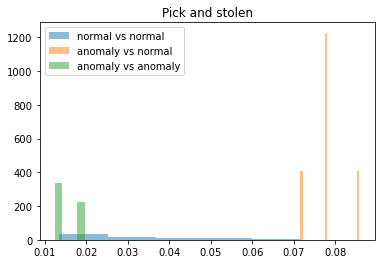

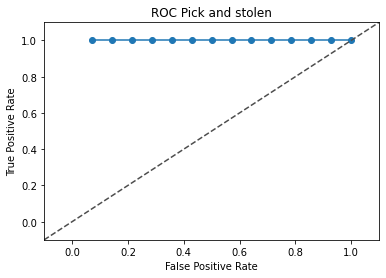

AUROC: 0.9285714285714285


In [93]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and stuck

## Loading pick and stuck data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/stuck/counts_got_stuck*.csv```

In [94]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and stuck'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/stuck'
ANOM_FILE_PREFIX = 'counts_got_stuck'

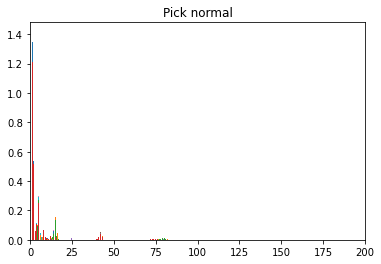

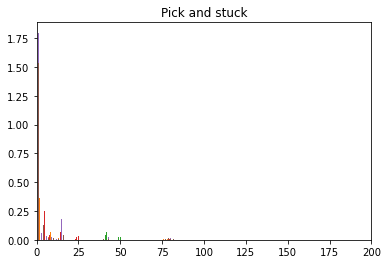

In [95]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and stuck KS Test

Anomaly Max dist: 0.12130632205820976  Anomaly Min dist:  0.010930770805850143
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 3 of 6 , accuracy:50.0%


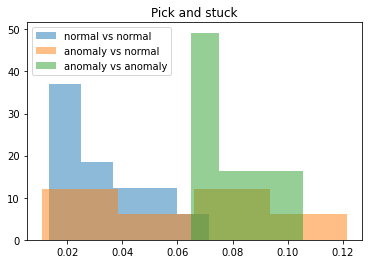

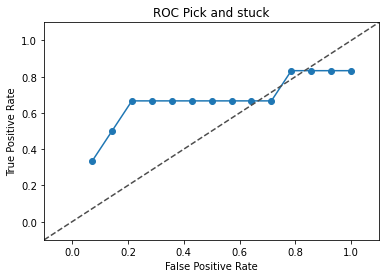

AUROC: 0.6369047619047619


In [96]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Real Panda

## Loading change object weight data

```data/real_panda/normal/counts_panda_normal*.csv```

```data/real_panda/abnormal/change_obj_weight/counts_panda_change_wieght*.csv```

In [97]:
TITLE_NORMAL = 'Real Panda'
TITLE_ANOMALY = 'Change object weight'
NORM_COUNTS_PATH = './data/real_panda/normal'
NORM_FILE_PREFIX = 'counts_panda_normal'
ANOMALY_COUNTS_PATH = './data/real_panda/abnormal/change_obj_weight'
ANOM_FILE_PREFIX = 'counts_panda_change_wieght'

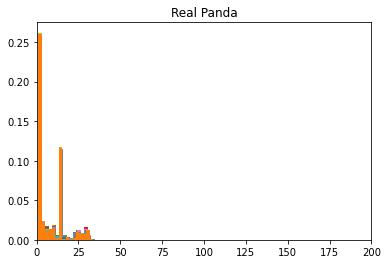

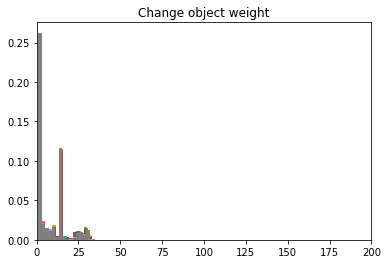

In [98]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.0033413862772111447  Anomaly Min dist:  0.0015154885821224706
Min distance of 90.0% confidence level: 0.003508748370046222
Total anomalies detected: 0 of 18 , accuracy:0.0%


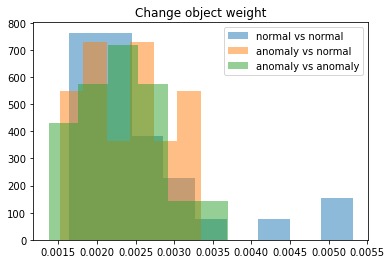

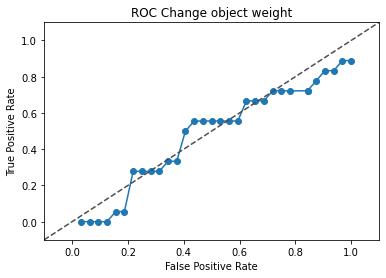

AUROC: 0.4722222222222222


In [99]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading gripper attack data

```data/real_panda/normal/counts_panda_normal*.csv```

```data/real_panda/abnormal/gripper_attack/counts_panda_gripper_attack*.csv```

In [100]:
TITLE_NORMAL = 'Real Panda'
TITLE_ANOMALY = 'Gripper attack'
NORM_COUNTS_PATH = './data/real_panda/normal'
NORM_FILE_PREFIX = 'counts_panda_normal'
ANOMALY_COUNTS_PATH = './data/real_panda/abnormal/gripper_attack'
ANOM_FILE_PREFIX = 'counts_panda_gripper_attack'

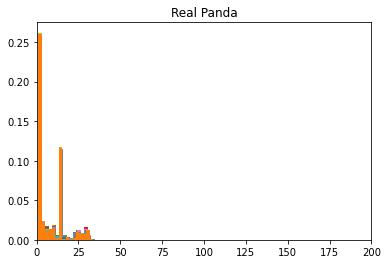

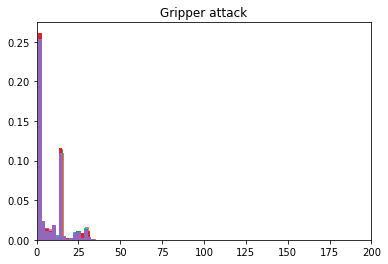

In [101]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.005556342045154428  Anomaly Min dist:  0.0009668962748361487
Min distance of 90.0% confidence level: 0.003508748370046222
Total anomalies detected: 9 of 15 , accuracy:60.0%


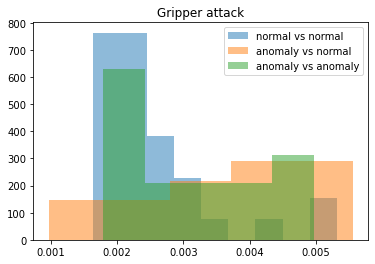

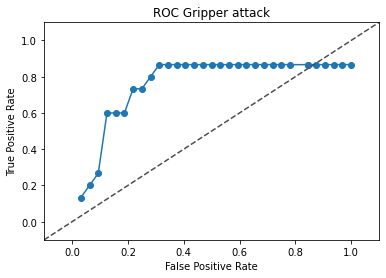

AUROC: 0.7531250000000003


In [102]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading low net connection data

```data/real_panda/normal/counts_panda_normal*.csv```

```data/real_panda/abnormal/low_net_connection/counts_panda_low_net_con*.csv```

In [103]:
TITLE_NORMAL = 'Real Panda'
TITLE_ANOMALY = 'Low net connection'
NORM_COUNTS_PATH = './data/real_panda/normal'
NORM_FILE_PREFIX = 'counts_panda_normal'
ANOMALY_COUNTS_PATH = './data/real_panda/abnormal/low_net_connection'
ANOM_FILE_PREFIX = 'counts_panda_low_net_con'

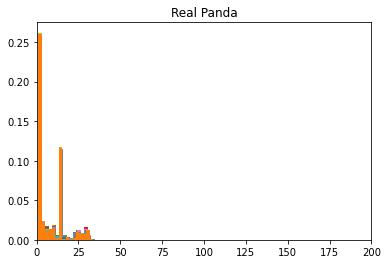

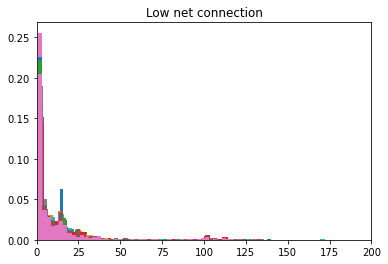

In [104]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.06884135180176487  Anomaly Min dist:  0.04576770467223035
Min distance of 90.0% confidence level: 0.003508748370046222
Total anomalies detected: 17 of 17 , accuracy:100.0%


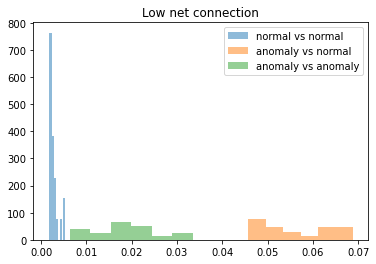

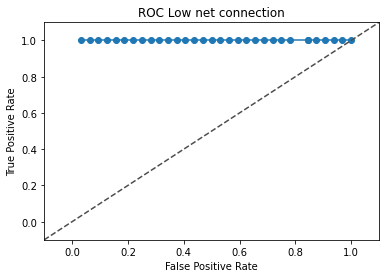

AUROC: 0.96875


In [105]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading miss bubble data

```data/real_panda/normal/counts_panda_normal*.csv```

```data/real_panda/abnormal/miss_bubble/counts_panda_miss_bubble*.csv```

In [106]:
TITLE_NORMAL = 'Real Panda'
TITLE_ANOMALY = 'Miss Bubble'
NORM_COUNTS_PATH = './data/real_panda/normal'
NORM_FILE_PREFIX = 'counts_panda_normal'
ANOMALY_COUNTS_PATH = './data/real_panda/abnormal/miss_bubble'
ANOM_FILE_PREFIX = 'counts_panda_miss_bubble'

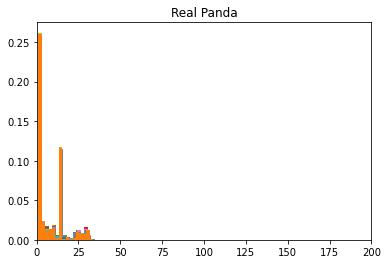

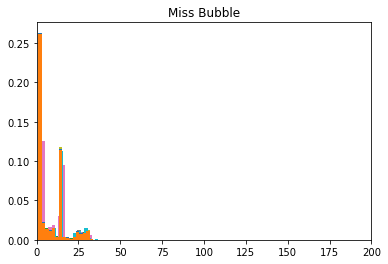

In [107]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.005702346930438362  Anomaly Min dist:  0.0017526536336470722
Min distance of 90.0% confidence level: 0.003508748370046222
Total anomalies detected: 2 of 12 , accuracy:16.666666666666668%


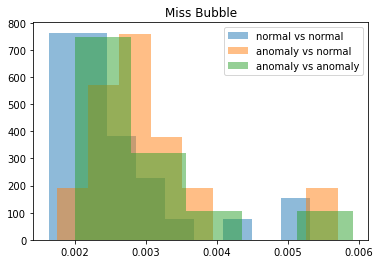

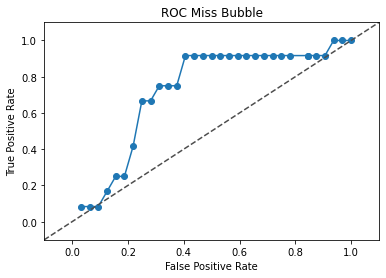

AUROC: 0.7174479166666665


In [108]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Real Turtlebot 3

## Loading collision data

```data/real_turtlebot3/normal/counts_real_turtle_normal*.csv```

```data/real_turtlebot3/abnormal/collision/counts_object_collision*.csv```

In [109]:
TITLE_NORMAL = 'Real Turtlebot 3'
TITLE_ANOMALY = 'Collision'
NORM_COUNTS_PATH = './data/real_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_real_turtle_normal'
ANOMALY_COUNTS_PATH = './data/real_turtlebot3/abnormal/collision'
ANOM_FILE_PREFIX = 'counts_object_collision'

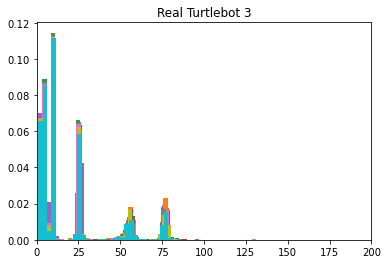

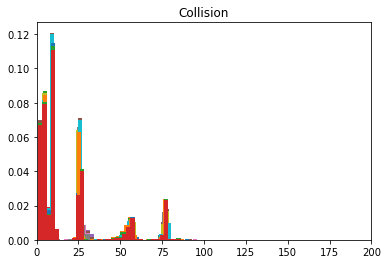

In [110]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.01838917651655758  Anomaly Min dist:  0.0031912902549332545
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 6 of 14 , accuracy:42.857142857142854%


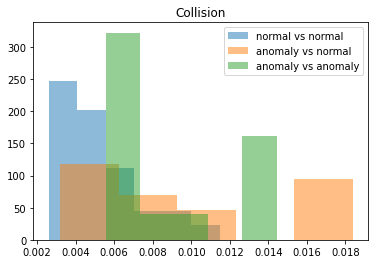

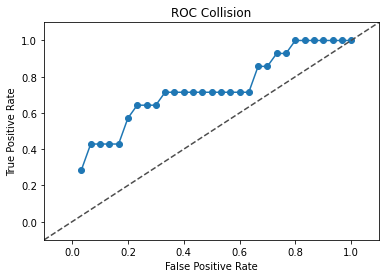

AUROC: 0.7190476190476189


In [111]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading hardware fault data

```data/real_turtlebot3/normal/counts_real_turtle_normal*.csv```

```data/real_turtlebot3/abnormal/hardware_fault/counts_hardware_fault*.csv```

In [112]:
TITLE_NORMAL = 'Real Turtlebot 3'
TITLE_ANOMALY = 'Hardware fault'
NORM_COUNTS_PATH = './data/real_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_real_turtle_normal'
ANOMALY_COUNTS_PATH = './data/real_turtlebot3/abnormal/hardware_fault'
ANOM_FILE_PREFIX = 'counts_hardware_fault'

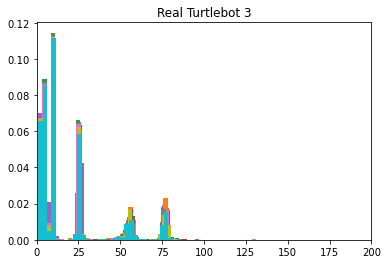

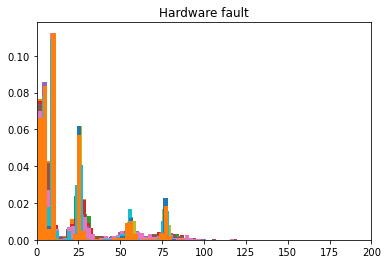

In [113]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.04075075221749058  Anomaly Min dist:  0.0027033986753025596
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 8 of 12 , accuracy:66.66666666666667%


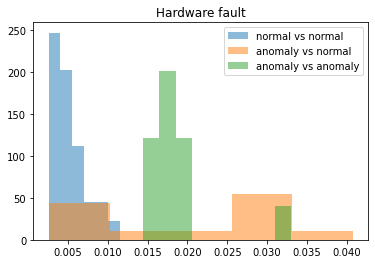

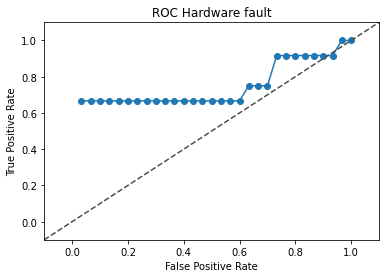

AUROC: 0.7277777777777779


In [114]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading low net connection data

```data/real_turtlebot3/normal/counts_real_turtle_normal*.csv```

```data/real_turtlebot3/abnormal/low_net_connection/counts_low_net_connection*.csv```

In [115]:
TITLE_NORMAL = 'Real Turtlebot 3'
TITLE_ANOMALY = 'Low net connection'
NORM_COUNTS_PATH = './data/real_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_real_turtle_normal'
ANOMALY_COUNTS_PATH = './data/real_turtlebot3/abnormal/low_net_connection'
ANOM_FILE_PREFIX = 'counts_low_net_connection'

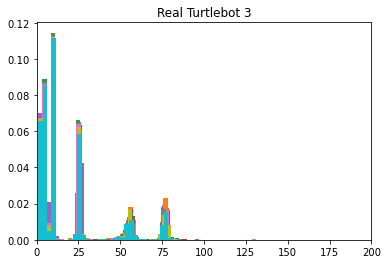

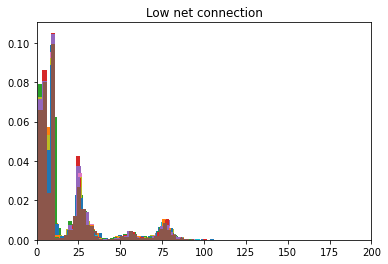

In [116]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.07750547473275915  Anomaly Min dist:  0.020490039230906976
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 16 of 16 , accuracy:100.0%


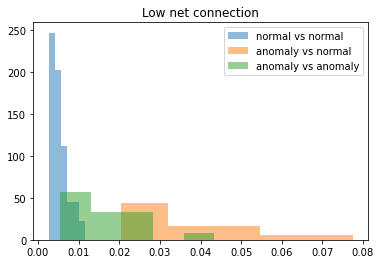

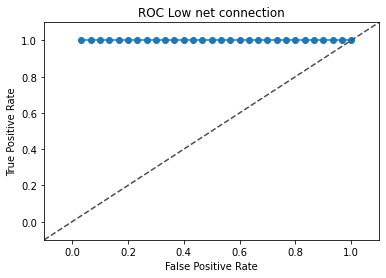

AUROC: 0.9666666666666667


In [117]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading unmapped obstacles data

```data/real_turtlebot3/normal/counts_real_turtle_normal*.csv```

```data/real_turtlebot3/abnormal/unmapped_obstacle/counts_unmapped_obstacle*.csv```

In [118]:
TITLE_NORMAL = 'Real Turtlebot 3'
TITLE_ANOMALY = 'Unmapped obstacles'
NORM_COUNTS_PATH = './data/real_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_real_turtle_normal'
ANOMALY_COUNTS_PATH = './data/real_turtlebot3/abnormal/unmapped_obstacle'
ANOM_FILE_PREFIX = 'counts_unmapped_obstacle'

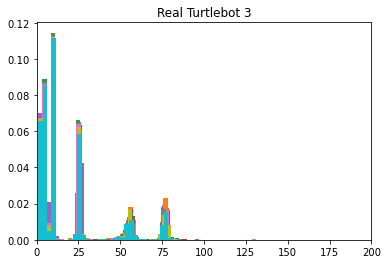

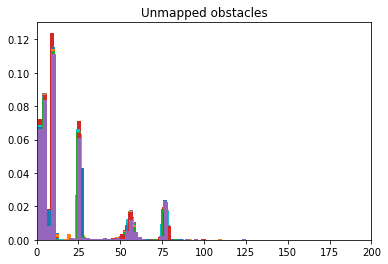

In [119]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.013332324797161843  Anomaly Min dist:  0.0026252008680813788
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 4 of 15 , accuracy:26.666666666666668%


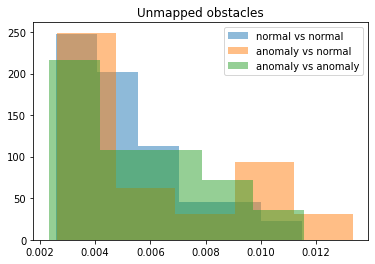

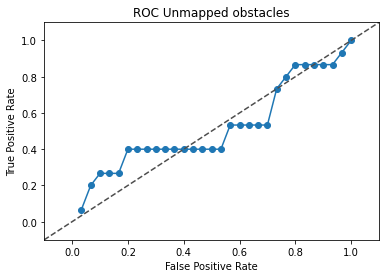

AUROC: 0.5133333333333334


In [120]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading velocity attack data

```data/real_turtlebot3/normal/counts_real_turtle_normal*.csv```

```data/real_turtlebot3/abnormal/velocity_attack/counts_velocity_attack*.csv```

In [121]:
TITLE_NORMAL = 'Real Turtlebot 3'
TITLE_ANOMALY = 'Velocity attack'
NORM_COUNTS_PATH = './data/real_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_real_turtle_normal'
ANOMALY_COUNTS_PATH = './data/real_turtlebot3/abnormal/velocity_attack'
ANOM_FILE_PREFIX = 'counts_velocity_attack'

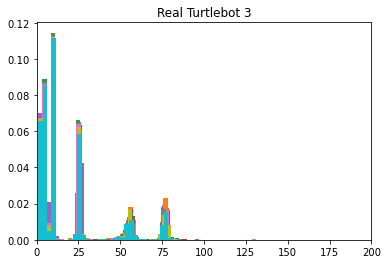

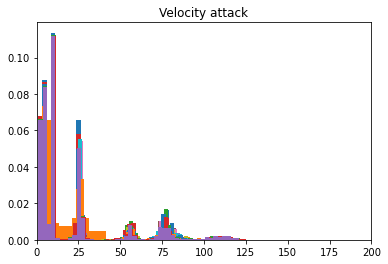

In [122]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.17514847407228817  Anomaly Min dist:  0.0057631269841846855
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 13 of 15 , accuracy:86.66666666666667%


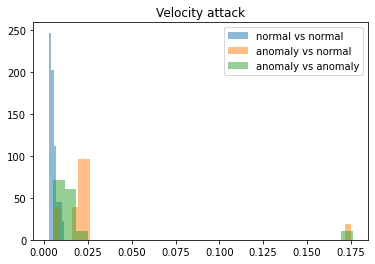

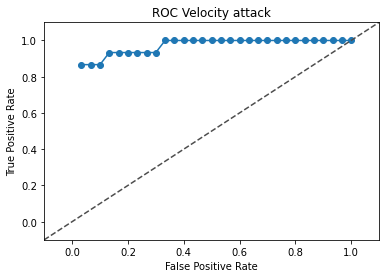

AUROC: 0.9422222222222222


In [123]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Sim Panda

## Loading collision data

```data/sim_panda/normal/counts_norm_sim_panda*.csv```

```data/sim_panda/abnormal/collision/counts_collision*.csv```

In [124]:
TITLE_NORMAL = 'Sim Panda'
TITLE_ANOMALY = 'Collision'
NORM_COUNTS_PATH = './data/sim_panda/normal'
NORM_FILE_PREFIX = 'counts_norm_sim_panda'
ANOMALY_COUNTS_PATH = './data/sim_panda/abnormal/collision'
ANOM_FILE_PREFIX = 'counts_collision'

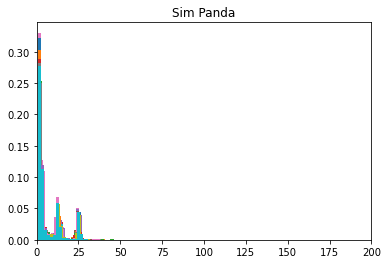

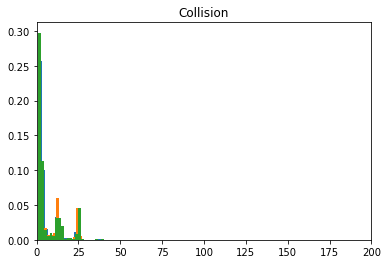

In [125]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.1079967019038473  Anomaly Min dist:  0.010263858766592415
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 3 of 3 , accuracy:100.0%


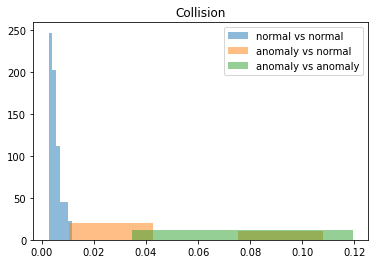

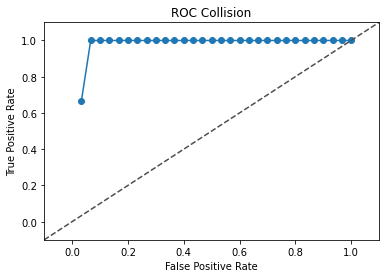

AUROC: 0.961111111111111


In [126]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading drop early data

```data/sim_panda/normal/counts_norm_sim_panda*.csv```

```data/sim_panda/abnormal/drop_early/counts_sim_panda_drop_early*.csv```

In [127]:
TITLE_NORMAL = 'Sim Panda'
TITLE_ANOMALY = 'Drop early'
NORM_COUNTS_PATH = './data/sim_panda/normal'
NORM_FILE_PREFIX = 'counts_norm_sim_panda'
ANOMALY_COUNTS_PATH = './data/sim_panda/abnormal/drop_early'
ANOM_FILE_PREFIX = 'counts_sim_panda_drop_early'

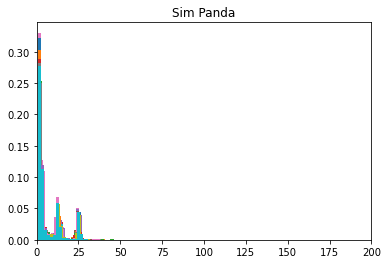

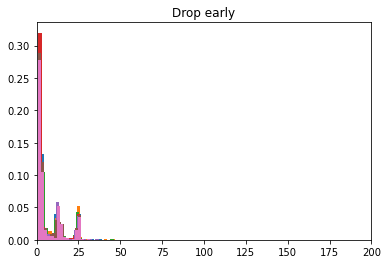

In [128]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.21061108098881465  Anomaly Min dist:  0.0066807825135905
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 5 of 7 , accuracy:71.42857142857143%


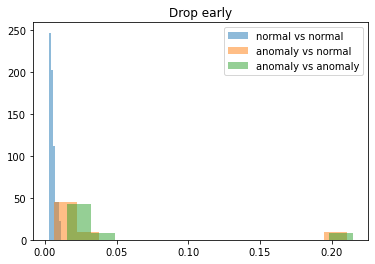

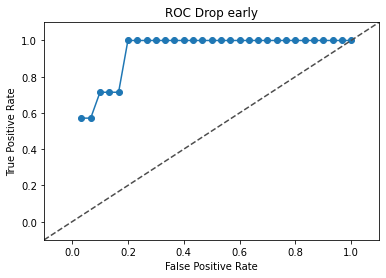

AUROC: 0.9166666666666666


In [129]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading gripper attack data

```data/sim_panda/normal/counts_norm_sim_panda*.csv```

```data/sim_panda/abnormal/gripper_attack/counts_sim_gripper_attack*.csv```

In [130]:
TITLE_NORMAL = 'Sim Panda'
TITLE_ANOMALY = 'Gripper Attach'
NORM_COUNTS_PATH = './data/sim_panda/normal'
NORM_FILE_PREFIX = 'counts_norm_sim_panda'
ANOMALY_COUNTS_PATH = './data/sim_panda/abnormal/gripper_attack'
ANOM_FILE_PREFIX = 'counts_sim_gripper_attack'

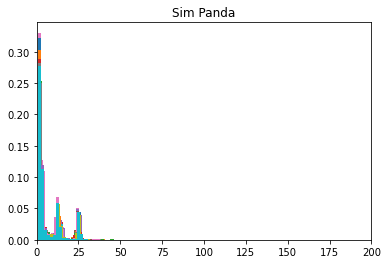

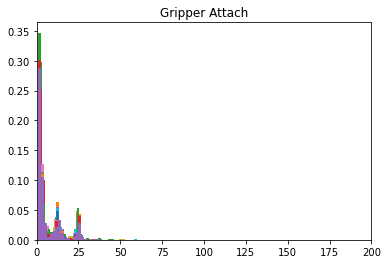

In [131]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.14555940140225132  Anomaly Min dist:  0.00511102941720476
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 14 of 15 , accuracy:93.33333333333333%


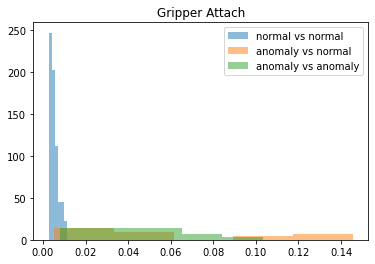

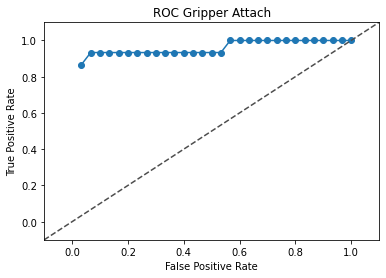

AUROC: 0.9311111111111109


In [132]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Sim turtlebot 3

## Loading laser fault data

```data/sim_turtlebot3/normal/counts_sim_normal*.csv```

```data/sim_turtlebot3/abnormal/laser_fault/counts_laser_fault*.csv```

In [133]:
TITLE_NORMAL = 'Sim Turtlebot 3'
TITLE_ANOMALY = 'Laser fault'
NORM_COUNTS_PATH = './data/sim_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_sim_normal'
ANOMALY_COUNTS_PATH = './data/sim_turtlebot3/abnormal/laser_fault'
ANOM_FILE_PREFIX = 'counts_laser_fault'

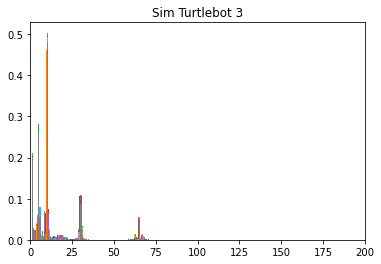

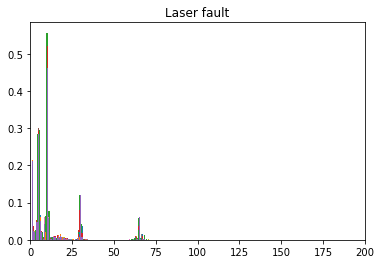

In [134]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.01190951440571586  Anomaly Min dist:  0.004858748894031706
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 3 of 15 , accuracy:20.0%


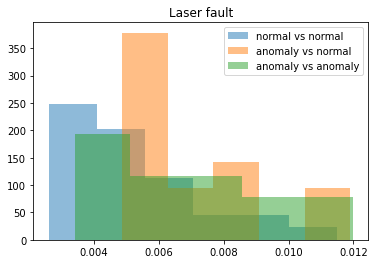

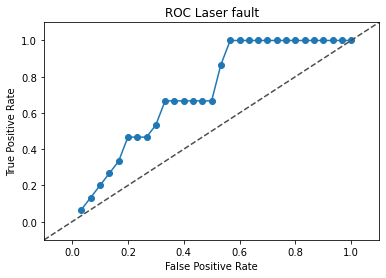

AUROC: 0.7088888888888889


In [135]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading unmapped obstacle data

```data/sim_turtlebot3/normal/counts_sim_normal*.csv```

```data/sim_turtlebot3/abnormal/unmapped_obstacle/counts_sim_unmapped_obs*.csv```

In [136]:
TITLE_NORMAL = 'Sim Turtlebot 3'
TITLE_ANOMALY = 'Unmapped obstacle'
NORM_COUNTS_PATH = './data/sim_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_sim_normal'
ANOMALY_COUNTS_PATH = './data/sim_turtlebot3/abnormal/unmapped_obstacle'
ANOM_FILE_PREFIX = 'counts_sim_unmapped_obs'

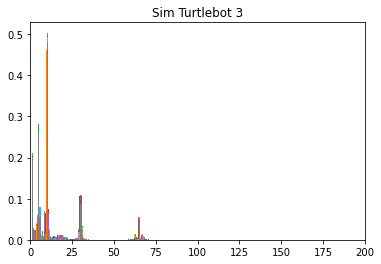

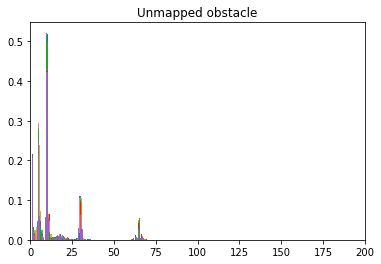

In [137]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.022478667186377366  Anomaly Min dist:  0.0037426672343646716
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 5 of 15 , accuracy:33.333333333333336%


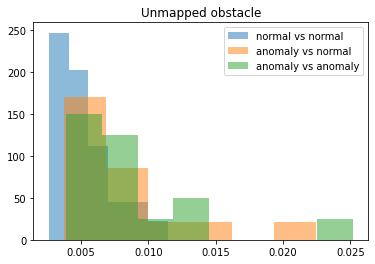

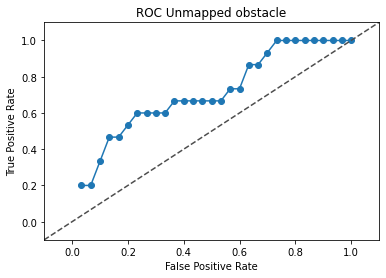

AUROC: 0.7044444444444444


In [138]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## Loading velocity attack data

```data/sim_turtlebot3/normal/counts_sim_normal*.csv```

```data/sim_turtlebot3/abnormal/velocity_attack/counts_sim_vel_atk*.csv```

In [139]:
TITLE_NORMAL = 'Sim Turtlebot 3'
TITLE_ANOMALY = 'Velocity attack'
NORM_COUNTS_PATH = './data/sim_turtlebot3/normal'
NORM_FILE_PREFIX = 'counts_sim_normal'
ANOMALY_COUNTS_PATH = './data/sim_turtlebot3/abnormal/velocity_attack'
ANOM_FILE_PREFIX = 'counts_sim_vel_atk'

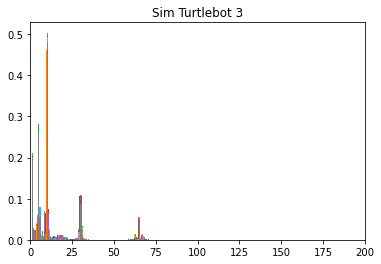

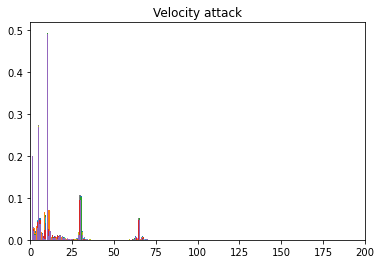

In [140]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

Anomaly Max dist: 0.02421680410610305  Anomaly Min dist:  0.00430578032054052
Min distance of 90.0% confidence level: 0.008811134679638455
Total anomalies detected: 5 of 15 , accuracy:33.333333333333336%


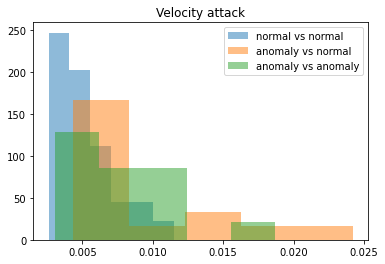

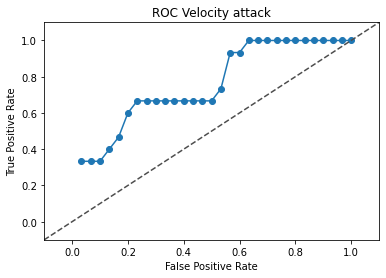

AUROC: 0.7466666666666667


In [141]:
s_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

## AUROC and Accuracy

In [142]:
print('Total Accuracy:', TOTAL_ACC/EXP_NUM)

Total Accuracy: 58.97741147741147


In [143]:
df = pd.DataFrame(AUROCs, columns=['Scenario', 'AUROC'])
df

,Scenario,AUROC
0,Building with laser fault,0.883333
1,Building with software fault,0.900000
2,Building with velocity attack,0.900000
3,Cans with Laser fault,0.121212
4,Cans with Obstacles,0.315476
5,Corr with Laser fault,0.918421
6,Corr with Obstacles,0.488304
7,Pick and miss cup,0.584821
8,Pick and restricted vision,0.928571
9,Pick and stolen,0.928571
